## Implement Eigen-entropy based time series signatures (EE - TSS)

##### Paper:
* Patharkar, A., Huang, J., Wu, T. *et al.* (2024)  
* [Eigen-entropy based time series signatures to support multivariate time series classification](https://www.nature.com/articles/s41598-024-66953-7)

In [1]:
from IPython.display import Image, display
from joblib import Parallel, delayed
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import utils1

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

##### *Illustrate EE - TSS with Heartbeat dataset.  This is binary classification of normal or abnormal heartbeat.*
* https://www.timeseriesclassification.com/description.php?Dataset=Heartbeat
* Challenge Details: https://physionet.org/content/challenge-2016/1.0.0/

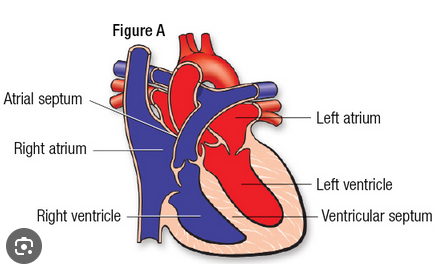

In [2]:
display(Image(filename='./images/heart_basic.PNG'))

Recordings were truncated to 5 seconds.


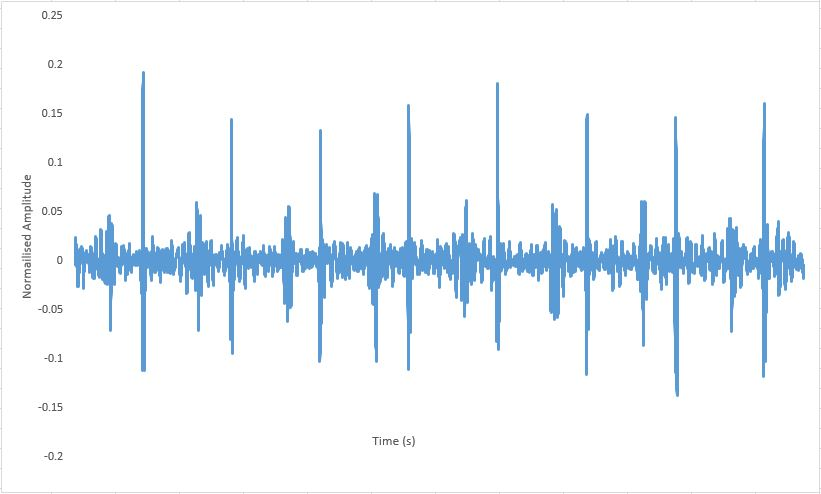

In [3]:
print('Recordings were truncated to 5 seconds.')
display(Image(filename='./images/Heartbeat.JPG', width=600))

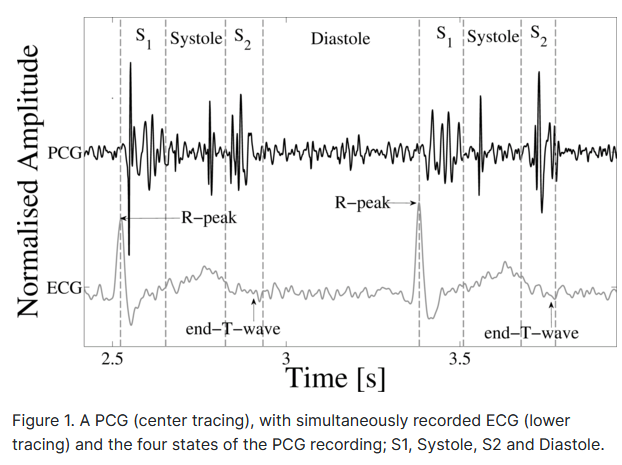

In [4]:
# Phonocardiogram and Echocardiograms
display(Image(filename='./images/PCG_tracings.PNG'))

### Code

In [5]:
# Helper Functions
        
def move_col(df, col_to_move, insert_index):
    cols = df.columns.tolist()
    cols.remove(col_to_move)
    cols.insert(insert_index, col_to_move)
    return df[cols]

def format_column_name(col, prefix):
    """Update column names."""
    return f"{prefix}{col}"

target_bytes_to_int_dict = {b'normal': 0, b'abnormal': 1,}

def tidy_format_heartbeat(df, turn_on_labels=False):
    '''Returns tidy format dataframe.  Rows are heart samples and columns
    are chartTSS.'''
    heart_samples = []
    for i in range(0, len(df)):
        temp_df = pd.DataFrame(data=df.Heartbeat.iloc[i]).T # transpose data
        temp_df.columns = [format_column_name(col=colname, prefix="f") for colname in temp_df.columns]  
        temp_df['target'] = df['target'].iloc[i]
        temp_df['samp'] = f"sample{i+1}"
        temp_df['att_num'] = pd.Series([f"{att_num}" for att_num in temp_df.index], index=temp_df.index)
        heart_samples.append(temp_df)
        
    # Concat list of dataframes and format columns.
    temp_df = pd.concat(heart_samples, ignore_index=True)
    temp_df= move_col(df=temp_df, col_to_move='att_num', insert_index=0)
    temp_df= move_col(df=temp_df, col_to_move='samp', insert_index=0)
    if turn_on_labels == False:
        temp_df = temp_df.drop(columns=['samp', 'att_num'])
    temp_df['target'] = temp_df['target'].map(target_bytes_to_int_dict)
    return temp_df

def sample_i_generator(X, samp_size):
    """Return heartbeat samples sequentially. samp_size is
    405 for heartbeat data."""
    for start_idx in range(0, len(X), samp_size):
        end_idx = start_idx + samp_size
        yield X.iloc[start_idx:end_idx, 2:-1]  # Excludes: 'samp', 'att_num', 'target'

In [6]:
# Load the ARFF file
train, meta = arff.loadarff('./data/Heartbeat_TRAIN.arff')
train = pd.DataFrame(train)

test, meta = arff.loadarff('./data/Heartbeat_TEST.arff')
test = pd.DataFrame(test)

In [7]:
# Heartbeat (Goldberger).  204 train samples. 205 test samples.  
# Each sample has 405 observations with 61 features.
X_train = tidy_format_heartbeat(train, turn_on_labels=True)
X_test = tidy_format_heartbeat(test, turn_on_labels=True)
train_samp_target = X_train.groupby('samp')['target'].first().to_dict()
test_samp_target = X_test.groupby('samp')['target'].first().to_dict()
print('X_train shape:', X_train.shape)
print('X test shape:', X_test.shape)
display(X_train.tail(2))
display(X_test.tail(2))

X_train shape: (82620, 64)
X test shape: (83025, 64)


,samp,att_num,f0,f1,f2,f3,f4,f5,f6,f7,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
82618,sample204,att404,0.008124,0.009142,0.005436,0.005101,0.007947,0.007861,0.000964,0.001796,...,0.014482,0.044743,0.050033,0.044775,0.10292,0.22650,0.27096,0.068071,0.062402,1
82619,sample204,att405,0.007120,0.006314,0.004198,0.003022,0.001614,0.008986,0.006300,0.004808,...,0.017493,0.048395,0.066491,0.012207,0.10891,0.12987,0.21613,0.130330,0.019614,1


,samp,att_num,f0,f1,f2,f3,f4,f5,f6,f7,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
83023,sample205,att404,0.008735,0.014895,0.009610,0.001591,0.001634,0.009404,0.010004,0.010706,...,0.010803,0.032996,0.023253,0.033891,0.100690,0.11785,0.32122,0.130270,0.014449,1
83024,sample205,att405,0.004821,0.008041,0.007629,0.004430,0.003733,0.005778,0.003724,0.007930,...,0.013638,0.030482,0.021975,0.025893,0.040776,0.25736,0.36338,0.082863,0.108340,1


### Visualization of certain Heatbeat features

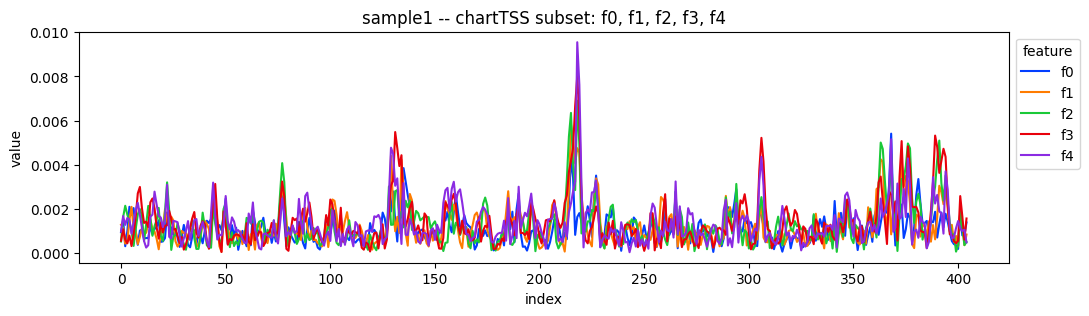

In [19]:
chartdata = X_train[(X_train["samp"] == 'sample1')].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(12, 3))
chartTSS = chartdata.columns[2:7]
colors = sns.color_palette("bright", len(chartTSS))

for i, feat in enumerate(chartTSS):
    sns.lineplot(data=chartdata, x=chartdata.index, y=feat, ax=ax, color=colors[i],label=feat)
# ax.set_yscale('log')
ax.set_xlabel('index')
ax.set_ylabel('value')
ax.set_title(f"{chartdata['samp'].iloc[0]} -- chartTSS subset: {', '.join(chartTSS)}")
plt.legend(title="feature", bbox_to_anchor=(1.0, 1.0), loc='upper left',)
plt.show()

### Eigen-entropy based time series signatures code (Algorithm 1)

In [9]:
def eigen_entropy(X, corr_method="spearman"):
    """Calculate the Eigen-Entropy of time series X.
    Check correlation method is right for the data.

    Parameters
    ----------
    X : 2D pd.DataFrame
        Time series
    scale : int
        Consecutive points to aggregate

    Returns
    -------
    coarse_ts : np.ndarray
        Array of coarse-grained time series with a given scale factor
    """

    # Get square corr matrix.
    corr_mag = X.corr(method=corr_method).abs()  # Spearman measures monotonic, non-linear relationships.

    # "w" is ASCII-friendly alternative to λ for eigenvalues.  "v" is for eigenvector;
    w, v = np.linalg.eig(corr_mag)
    w = np.real_if_close(w, tol=1)
    w_sum = np.sum(w)  # matric trace - sum of eigenvalues on diagonal (w)

    # Eigenvalues (w) are global properties of the square corr matrix.
    prob_vec = w / w_sum  # vec sums up to 1.
    if np.any(prob_vec <= 0):
        # display(f"prob_vec numbers must be >0 for log. {prob_vec} || X shape: {X.shape}")
        prob_vec = np.where(prob_vec > 0, prob_vec, 1e-6)   # replace negatives with 1e-6
    ent_i_vec = -(prob_vec) * np.log(prob_vec)
    ent_scalar = np.sum(ent_i_vec)
    return ent_scalar

In [10]:
def calc_TSS_for_sample(samp, cg_scales, samp_num):
    """Return Time Series Signature (TSS) for all coarse-grained scales.

    Parameters
    ----------
    samp : 2D pd.DataFrame
        Single sample time series
    cg_scales : int
        List of scales.  This is consecutive points to average.
    samp_num : int
        Sample number.

    Returns
    -------
    TSS : pd.DataFrame
        Time Series Signature Dataframe with len(cg_X)//SS rows and
        len(cg_scales) columns.
    """
    scales = []
    for scl in cg_scales:

        # Initialize TSS variables
        cg_X = utils1.coarse_time_series(X=samp, scale=scl)
        SS = max(int(len(cg_X) / 50), 2)  # sample size increment.
        EE_first = eigen_entropy(X=cg_X.iloc[0:SS])

        # Loop through sample Cumulative Moving Windows at the cg scale
        TSS = []
        for i, win_index in enumerate(range(SS, len(cg_X), SS)):
            CMW = cg_X.iloc[0:win_index]
            ee = eigen_entropy(X=CMW)
            TSS_i = (ee - EE_first) / (i + 1)  # CHEE divided by number of CMWs
            TSS.append(TSS_i)
        scales.append(pd.Series(TSS, name=f"TSS_scl{scl}"))
        if len(scales) > 1:
            if len(scales[-1]) != len(scales[-2]): print("The number of TSS points changed from the last scale.  Do you want this scale?  Returned TSS will include NaNs.")

    # Concat the TSS at the cg_scales into a matrix.
    TSS_matrix = pd.concat(scales, axis=1, ignore_index=False)
    TSS_matrix["samp"] = f"sample{samp_num}"
    return TSS_matrix

In [11]:
def compile_TSS_sample_matrices(X, samp_size, cg_scales, samp_target_mapping):
    """Combine the TSS matrix from each sample.  Add back sample targets to
    the TSS format.

    Parameters
    ----------
    X : 2D pd.DataFrame
        Time series data with multiple samples
    samp_size : int
        Observations in sample
    cg_scales : List[int]
        List of scales.  This is consecutive points to average.
    samp_target_mapping : Dict
        Maps sample_i to its target value.  Required because TSS
        transformation has fewer rows than X.

    Returns
    -------
    TSS : pd.DataFrame
        Time Series Signature Dataframe.  Note the lower dimesions than X:
        rows = len(cg_X)//SS and
        cols = len(cg_scales).
    """
    all_samples_df_list = []
    gen = sample_i_generator(X=X, samp_size=samp_size)
    all_samples_df_list = Parallel(n_jobs=-3)(delayed(calc_TSS_for_sample)(samp, cg_scales, samp_i+1) for samp_i, samp in enumerate(gen)) # 1st sample is 1

    all_samples_df = pd.concat(all_samples_df_list, axis=0, ignore_index=True)
    all_samples_df["target"] = all_samples_df["samp"].map(samp_target_mapping)
    return all_samples_df.drop(columns="samp")

#### Visualize EE -TSS features
* Each sample has 50 indices
* Originally each sample had 405 indices (time series observations)

In [12]:
TSS_trainX = compile_TSS_sample_matrices(X=X_train, samp_size=405, cg_scales=[1,2,4], samp_target_mapping=train_samp_target)
TSS_testX = compile_TSS_sample_matrices(X=X_test, samp_size=405, cg_scales=[1,2,4], samp_target_mapping=test_samp_target)
TSS_trainy = TSS_trainX.pop('target')
TSS_testy = TSS_testX.pop('target')

print('TSS_trainX shape', TSS_trainX.shape, '|| TSS_testX shape:', TSS_testX.shape)
print('TSS_trainy shape', TSS_trainy.shape, '  || TSS_testy shape:', TSS_testy.shape)

TSS_trainX shape (10200, 3) || TSS_testX shape: (10250, 3)
TSS_trainy shape (10200,)   || TSS_testy shape: (10250,)


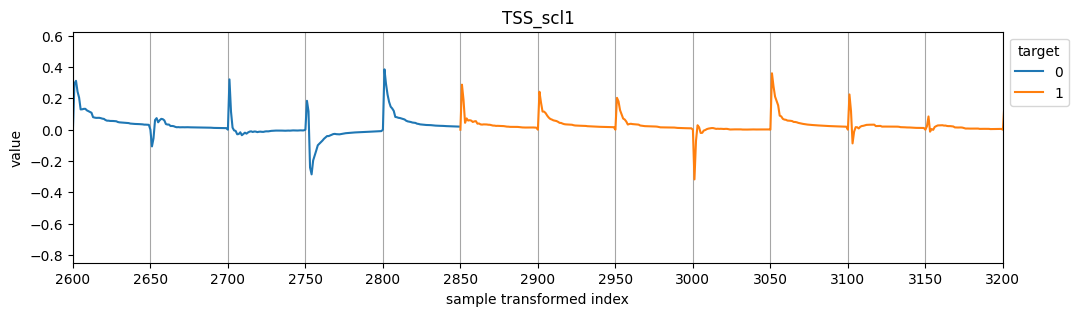

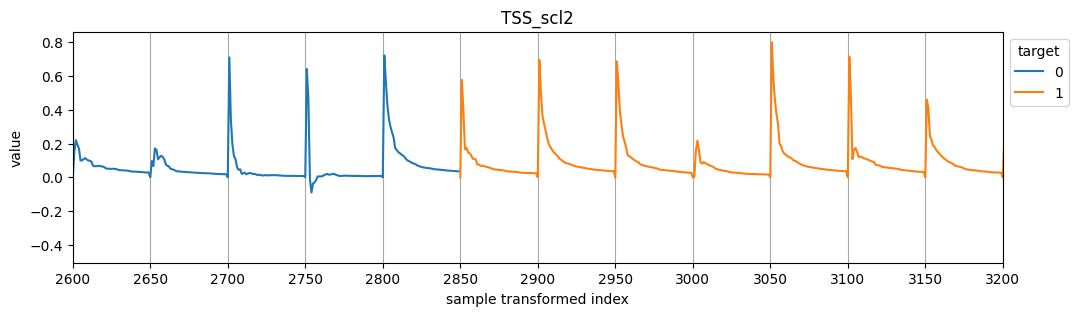

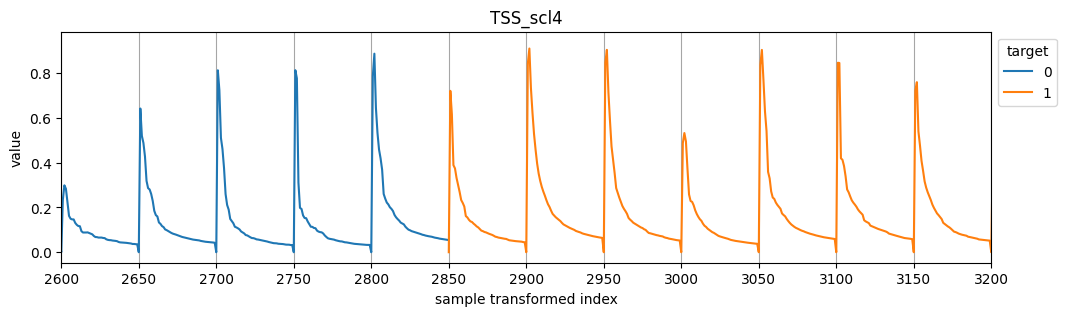

In [13]:
def plot_data(df: pd.DataFrame, column,):
    colors = sns.color_palette(palette="bright", n_colors=10)
    fig, ax = plt.subplots(figsize=(12, 3))
    chartTSS = df.columns
    sns.lineplot(data=df, x=df.index, y=df[column], ax=ax, hue=df.target) #color=colors[chart_num],

    samp_indices = np.arange(0, len(TSS_trainX)+1, 50)    
    ax.set_xticks(samp_indices)
    ax.set_xticklabels([str(x) for x in samp_indices])    
    ax.set_xlim(2600,3200) 
    ax.set_xlabel("sample transformed index")
    ax.set_ylabel("value")
    ax.grid(axis='x', color='gray', alpha=0.7)
    ax.set_title(f"{column}")
    plt.legend(title="target", bbox_to_anchor=(1.0, 1.0),loc="upper left",)
    plt.show()

chartTSS = TSS_trainX.copy()
chartTSS["target"] = TSS_trainy
for col in chartTSS.columns[0:-1]:    
    plot_data(chartTSS, col)

#### Model EE -TSS features: Classify with Ridge Classifier.
* Remember Normal Hearbeat = 0 and Abnormal Heartbeat = 1
* We want to catch all the Abnormals, so Recall is the key metric.
* Recall = TP/(TP+FN)

In [14]:
# Score TSS data with Ridge Classification.  In this case, the sample size increment (SS) was 8 for the cumulative moving window (CMW).  So there's one-eighth the observations.
# Read the "Algorithm 1" illustration in the paper to understand the details.
avg_type = 'weighted'
for model in [RidgeClassifier()]:
    model.fit(TSS_trainX, TSS_trainy)
    y_pred  = pd.Series(model.predict(TSS_testX))
    print('-------------------------')
    print('####', model, '####')
    utils1.confusion_matrix_values(TSS_testy, y_pred)
    print('\n')
    print('wt recall:', round(recall_score(TSS_testy, y_pred, average=avg_type),4))
    print('wt precision:', round(precision_score(TSS_testy, y_pred, average=avg_type),4))
    print('wt f1:', round(f1_score(TSS_testy, y_pred, average=avg_type),4))

-------------------------
#### RidgeClassifier() ####
TP: 7400 || FP: 2848 || TN: 2 || FN: 0 || Total: 10250
   recall: 1.0
precision: 0.7221
 accuracy: 0.7221
       f1: 0.8386
      CSI: 0.7221


wt recall: 0.7221
wt precision: 0.7994
wt f1: 0.6058


##### Note all abnormal heartbeats (positive class) were correctly classified.  There were zero False Negatives (FN).  So Recall is perfect at 1.0.  Call it Total Recall! :-)

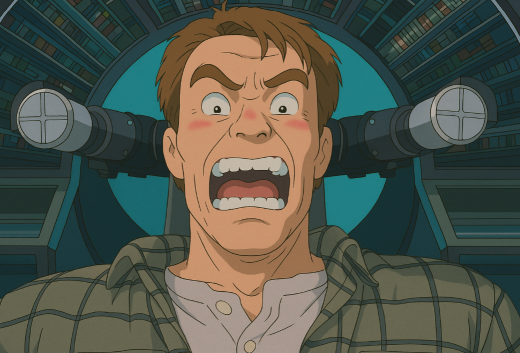

In [15]:
display(Image(filename='./images/total_recall1.PNG', width=500))

In [16]:
# Score original data (which in this case has 8x the data points) with Ridge Classification
if 'target' in X_train.columns:
    y_train = X_train.pop('target')
    y_test = X_test.pop('target')

avg_type = 'weighted'
for model in [RidgeClassifier()]:
    model.fit(X_train.select_dtypes(include='number'), y_train)
    y_pred  = pd.Series(model.predict(X_test.select_dtypes(include='number')))
    print('-------------------------')
    print('####', model, '####')
    utils1.confusion_matrix_values(y_test, y_pred)
    print('\n')
    print('wt recall:', round(recall_score(y_test, y_pred, average=avg_type),4))
    print('wt precision:', round(precision_score(y_test, y_pred, average=avg_type),4))
    print('wt f1:', round(f1_score(y_test, y_pred, average=avg_type),4))

-------------------------
#### RidgeClassifier() ####
TP: 59125 || FP: 22330 || TN: 755 || FN: 815 || Total: 83025
   recall: 0.9864
precision: 0.7259
 accuracy: 0.7212
       f1: 0.8363
      CSI: 0.7187


wt recall: 0.7212
wt precision: 0.6577
wt f1: 0.6208


In [17]:
#### CSI = Critical Success Index